# Bias–Variance Tradeoff (with SGD + PyTorch)

#### Author: Matteo Caorsi

This notebook builds a **very concrete** bias–variance experiment.

We generate data from:
$$ y \sim \mathcal{N}(x^2, \sigma), \quad \sigma = 0.5, \quad x \in [0, 1]. $$

Then we:
- sample many datasets
- fit models with **SGD** (PyTorch)
- estimate **bias** and **variance** as functions of model complexity
- push the polynomial degree high (up to 100) to look for **double descent**.


In [1]:
# Imports & setup
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
rng = np.random.default_rng(0)

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True


## 1) Data-generating model

Ground truth:
- Mean function: $f(x) = x^2$
- Noise: $\epsilon \sim \mathcal{N}(0, \sigma)$ with $\sigma=0.5$
- Observations: $y = f(x) + \epsilon$


In [2]:
def f_true(x: np.ndarray) -> np.ndarray:
    """Ground truth mean function: f(x) = x^2."""
    return x**2

def sample_dataset(n_points: int = 11, sigma: float = 0.5, x_grid: np.ndarray | None = None, seed: int | None = None):
    """Sample one dataset (x in [0,1], y ~ N(x^2, sigma))."""
    local_rng = np.random.default_rng(seed)
    if x_grid is None:
        x_grid = np.linspace(0.0, 1.0, n_points)
    mu = f_true(x_grid)
    y = local_rng.normal(loc=mu, scale=sigma, size=len(x_grid))
    return x_grid.astype(np.float64), y.astype(np.float64)

# Fixed x grid: spaced by 0.1 across [0,1] -> 11 points.
# The prompt says 10 points spaced by 0.1; that is inconsistent with the interval [0,1] unless you drop an endpoint.
# We'll use 11 points (0.0, 0.1, ..., 1.0) to match the 0.1 spacing exactly.
x_grid = np.linspace(0.0, 1.0, 11)
len(x_grid), x_grid[:3], x_grid[-3:]


(11, array([0. , 0.1, 0.2]), array([0.8, 0.9, 1. ]))

## 2) Plot the actual distribution and the parabola of its expectation

We visualize the 2D distribution by drawing many samples and plotting them (alpha-blended), plus the curve $x^2$.


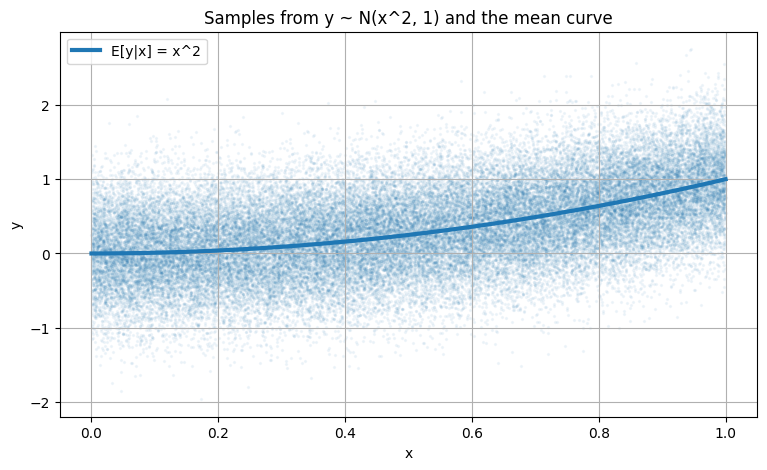

In [3]:
def plot_distribution(sigma: float = 0.5, n_samples: int = 50_000):
    x = rng.uniform(0.0, 1.0, size=n_samples)
    y = rng.normal(loc=f_true(x), scale=sigma, size=n_samples)

    plt.figure()
    plt.scatter(x, y, s=2, alpha=0.05)
    xs = np.linspace(0.0, 1.0, 400)
    plt.plot(xs, f_true(xs), linewidth=3, label="E[y|x] = x^2")
    plt.title("Samples from y ~ N(x^2, 1) and the mean curve")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

plot_distribution(sigma=0.5)


## 3) Sample multiple datasets

We sample **20 datasets**, each on the same x-grid, and each y-value is sampled independently.


In [4]:
def sample_many_datasets(n_datasets: int = 20, sigma: float = 0.5, x_grid: np.ndarray = x_grid, seed: int = 0):
    datasets = []
    base_rng = np.random.default_rng(seed)
    seeds = base_rng.integers(0, 10_000_000, size=n_datasets)
    for s in seeds:
        x, y = sample_dataset(n_points=len(x_grid), sigma=sigma, x_grid=x_grid, seed=int(s))
        datasets.append((x, y))
    return datasets

datasets = sample_many_datasets(n_datasets=20, sigma=0.5, x_grid=x_grid, seed=42)
len(datasets), datasets[0][0].shape, datasets[0][1].shape


(20, (11,), (11,))

Quick visualization of all 20 datasets:

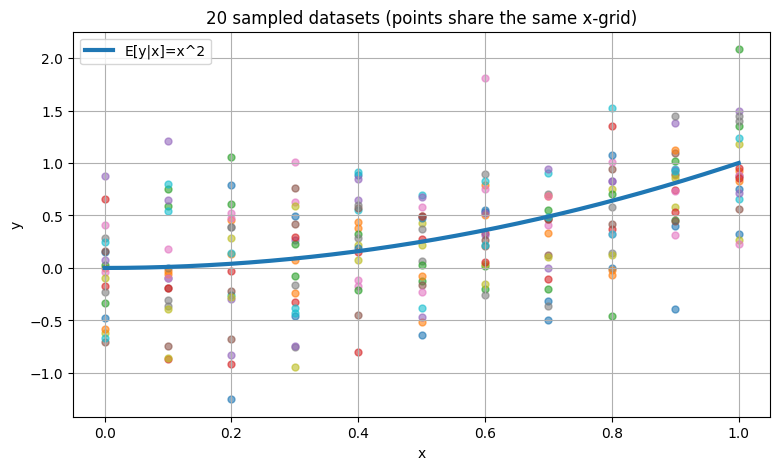

In [5]:
plt.figure()
for (x, y) in datasets:
    plt.scatter(x, y, s=25, alpha=0.6)
xs = np.linspace(0.0, 1.0, 400)
plt.plot(xs, f_true(xs), linewidth=3, label="E[y|x]=x^2")
plt.title("20 sampled datasets (points share the same x-grid)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


## 4) Fit a line with SGD (PyTorch)

For each dataset, we fit:
$$ \hat{y}(x) = b + wx $$
using PyTorch + **SGD**.


In [6]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.b = nn.Parameter(torch.zeros(()))
        self.w = nn.Parameter(torch.zeros(()))

    def forward(self, x):
        return self.b + self.w * x

def train_sgd(model: nn.Module, x: np.ndarray, y: np.ndarray, lr: float = 0.1, epochs: int = 2000, batch_size: int | None = None):
    """Train with plain SGD (optionally minibatched)."""
    x_t = torch.tensor(x)
    y_t = torch.tensor(y)
    opt = torch.optim.SGD(model.parameters(), lr=lr)

    n = len(x)
    if batch_size is None:
        batch_size = n

    for _ in range(epochs):
        perm = torch.randperm(n)
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            pred = model(x_t[idx])
            loss = torch.mean((pred - y_t[idx])**2)
            opt.zero_grad()
            loss.backward()
            opt.step()

    return model

def fit_line_for_dataset(x, y, lr=0.1, epochs=2500, batch_size=None):
    model = LinearModel()
    model = train_sgd(model, x, y, lr=lr, epochs=epochs, batch_size=batch_size)
    with torch.no_grad():
        b = float(model.b.detach().cpu().numpy())
        w = float(model.w.detach().cpu().numpy())
    return b, w

line_params = [fit_line_for_dataset(x, y, lr=0.1, epochs=2500, batch_size=len(x)) for (x, y) in datasets]
line_params[:3]


[(0.00034872397336376546, 0.033292440277194205),
 (-0.1167487980095607, 0.7606011431317896),
 (0.012122216155730956, 0.7190803252242782)]

## 5) Plot all the lines together

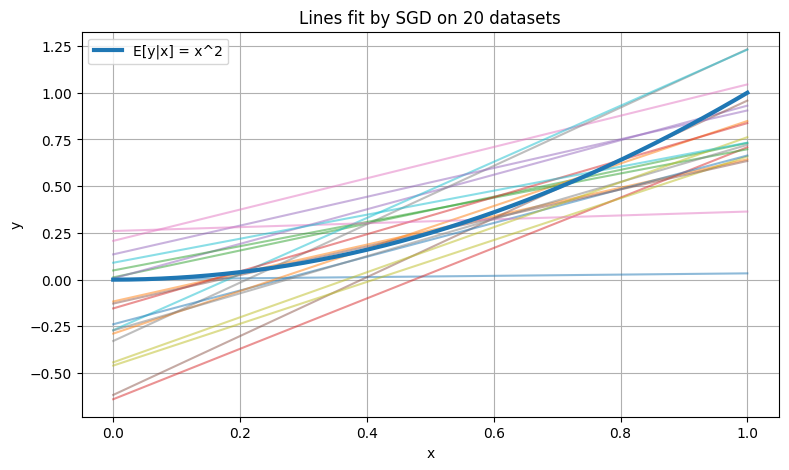

In [7]:
plt.figure()
xs = np.linspace(0.0, 1.0, 200)
for (b, w) in line_params:
    plt.plot(xs, b + w*xs, alpha=0.5)
plt.plot(xs, f_true(xs), linewidth=3, label="E[y|x] = x^2")
plt.title("Lines fit by SGD on 20 datasets")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


## 6) Histograms of $f_D(x)$ for each x (across datasets)

For each x-grid location, we gather the 20 $f_D(x)$-values (one per dataset) and plot histograms **side by side**.


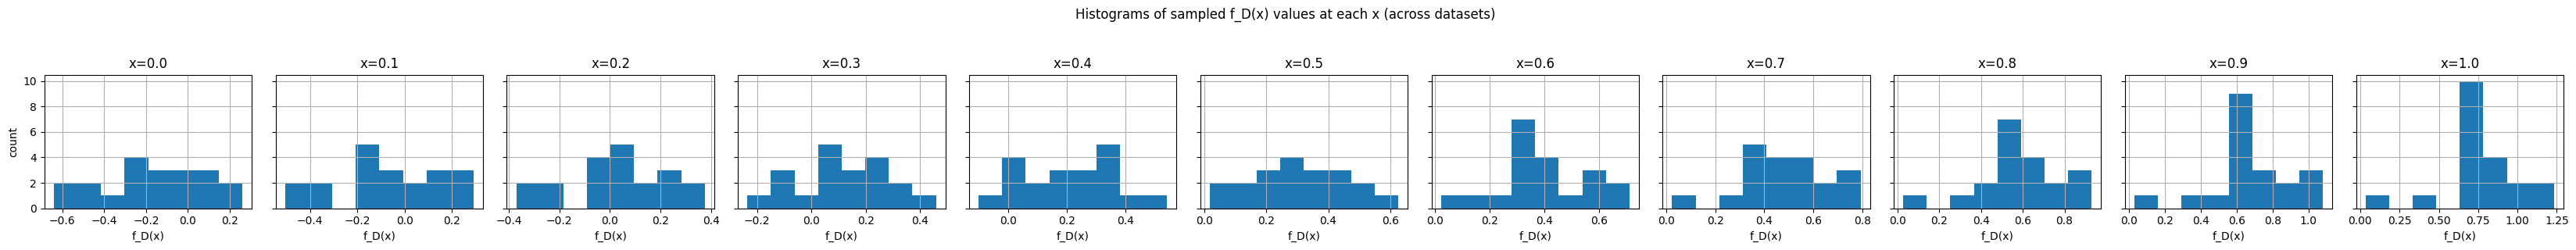

In [8]:
def collect_y_by_x(datasets, x_grid):
    # assumes each dataset uses the same x_grid
    Y = np.stack([y for (_, y) in datasets], axis=0)  # (n_datasets, n_x)
    return Y

def collect_fD_by_x(datasets, x_grid, n_points: int = 11):
    # assumes each dataset uses the same x_grid
    xs = np.linspace(0.0, 1.0, n_points)
    fDX = np.stack([xs*w + b for (b, w) in line_params], axis=0)  # (n_datasets, n_x)
    return fDX

# Y = collect_y_by_x(datasets, x_grid)  # (20, 11)
fDX = collect_fD_by_x(datasets, x_grid)  # (20, 11)
fig, axes = plt.subplots(1, len(x_grid), figsize=(3*len(x_grid), 3), sharey=True)
for j, xval in enumerate(x_grid):
    axes[j].hist(fDX[:, j], bins=8)
    axes[j].set_title(f"x={xval:.1f}")
    axes[j].set_xlabel("f_D(x)")
axes[0].set_ylabel("count")
fig.suptitle("Histograms of sampled f_D(x) values at each x (across datasets)", y=1.05)
plt.tight_layout()
plt.show()


## 7) Expectation of $f_D(x)$ for all x

We estimate $\mathbb{E}[y\mid x]$ empirically (mean across datasets at each x) and plot it vs the true $x^2$.


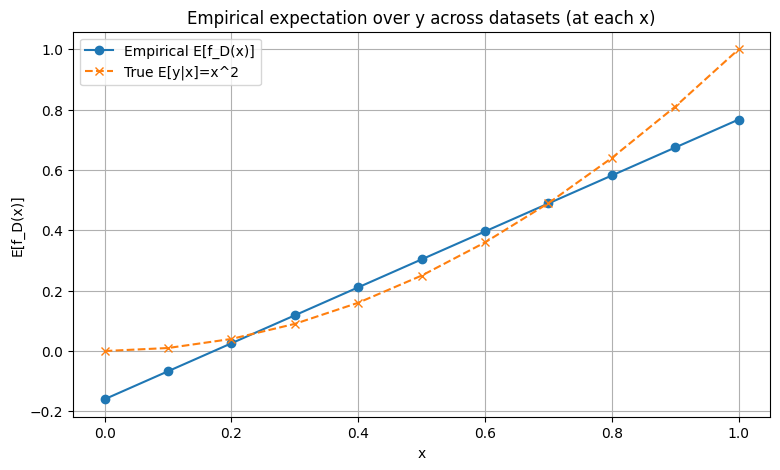

In [9]:
Ey = fDX.mean(axis=0)

plt.figure()
plt.plot(x_grid, Ey, marker="o", label="Empirical E[f_D(x)]")
plt.plot(x_grid, f_true(x_grid), marker="x", linestyle="--", label="True E[y|x]=x^2")
plt.title("Empirical expectation over y across datasets (at each x)")
plt.xlabel("x")
plt.ylabel("E[f_D(x)]")
plt.legend()
plt.show()


## 8) Bias and variance for each x (for the fitted predictor)

Now we move from the *data* distribution to the *learned predictor* distribution.

For each dataset $d$, we trained a predictor $\hat f_d(x)$ (a line). We estimate:
- mean predictor: $\mathbb{E}_d[\hat f_d(x)]$
- variance: $\mathrm{Var}_d(\hat f_d(x))$
- bias (signed): $\mathbb{E}_d[\hat f_d(x)] - f(x)$


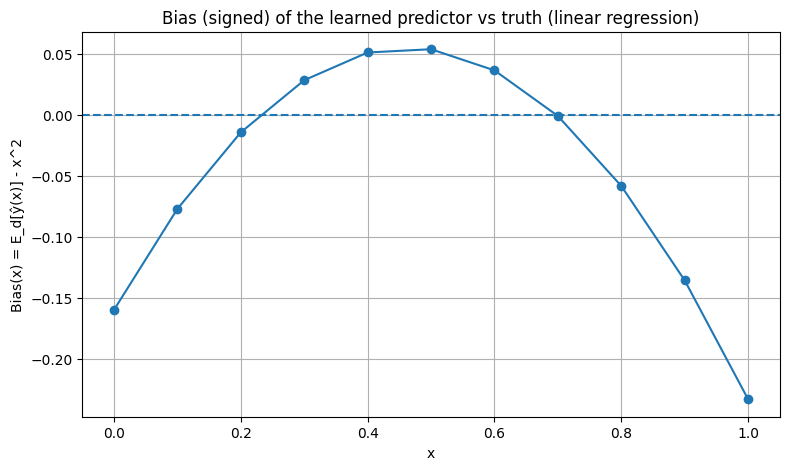

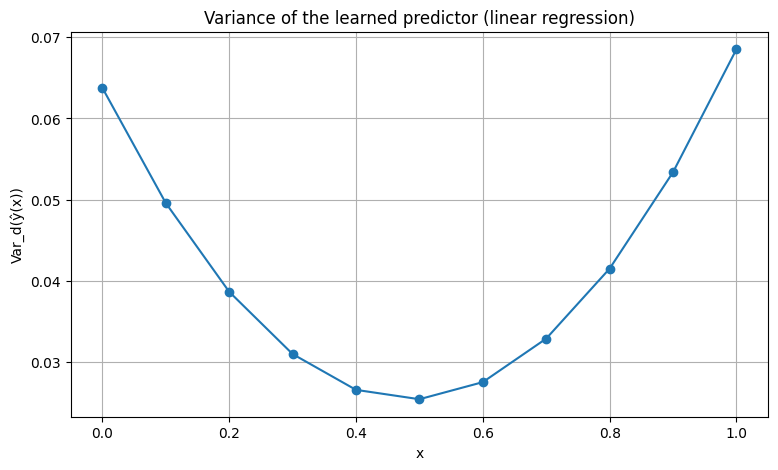

(0.010477791010187582, 0.04169691071240301)

In [10]:
Yhat = collect_fD_by_x(line_params, x_grid)

Ehat = Yhat.mean(axis=0)
Vhat = Yhat.var(axis=0, ddof=0)
bias = Ehat - f_true(x_grid)
bias2 = bias**2

plt.figure()
plt.plot(x_grid, bias, marker="o")
plt.axhline(0.0, linestyle="--")
plt.title("Bias (signed) of the learned predictor vs truth (linear regression)")
plt.xlabel("x")
plt.ylabel("Bias(x) = E_d[ŷ(x)] - x^2")
plt.show()

plt.figure()
plt.plot(x_grid, Vhat, marker="o")
plt.title("Variance of the learned predictor (linear regression)")
plt.xlabel("x")
plt.ylabel("Var_d(ŷ(x))")
plt.show()

bias2_mean = float(bias2.mean())
var_mean = float(Vhat.mean())
bias2_mean, var_mean


## 9) Bias–variance as model complexity increases (polynomials)

We generalize the model from:
- degree 0: constant $\hat y=b$
- degree 1: line
- ...
- degree 9: can interpolate 10–11 points (depending on grid size), in principle
- and beyond.

We keep training with **SGD**.

### Polynomial model
We fit:
$$ \hat y(x) = \sum_{k=0}^{d} a_k x^k. $$

To make SGD numerically stable for large degrees (like 100), we:
- map $x \in [0,1]$ to $z \in [-1,1]$
- build powers of $z$
- standardize each feature column (except the constant term).


In [11]:
def poly_features(x: np.ndarray, degree: int) -> np.ndarray:
    """Standardized polynomial features up to given degree."""
    z = 2.0*x - 1.0
    X = np.stack([z**k for k in range(degree + 1)], axis=1)  # (n, degree+1)

    if degree >= 1:
        cols = X[:, 1:]
        mean = cols.mean(axis=0, keepdims=True)
        std = cols.std(axis=0, keepdims=True) + 1e-12
        cols = (cols - mean) / std
        X[:, 1:] = cols
    return X

class PolyRegressor(nn.Module):
    def __init__(self, degree: int):
        super().__init__()
        self.degree = degree
        self.a = nn.Parameter(torch.zeros(degree + 1))

    def forward(self, X):
        return X @ self.a

def fit_poly_sgd(x: np.ndarray, y: np.ndarray, degree: int, lr: float = 0.1, epochs: int = 6000, batch_size: int | None = None):
    X = poly_features(x, degree)
    X_t = torch.tensor(X)
    y_t = torch.tensor(y)

    model = PolyRegressor(degree)
    opt = torch.optim.SGD(model.parameters(), lr=lr)

    n = len(x)
    if batch_size is None:
        batch_size = n

    for _ in range(epochs):
        perm = torch.randperm(n)
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            pred = model(X_t[idx])
            loss = torch.mean((pred - y_t[idx])**2)
            opt.zero_grad()
            loss.backward()
            opt.step()

    return model

def predict_poly(model: PolyRegressor, x_grid: np.ndarray) -> np.ndarray:
    Xg = poly_features(x_grid, model.degree)
    with torch.no_grad():
        yhat = model(torch.tensor(Xg)).detach().cpu().numpy()
    return yhat


### 10) Helper: estimate bias^2 and variance vs degree

For each degree:
1. Train one model per dataset (SGD)
2. Predict on the x-grid
3. Compute mean predictor, bias^2, and variance across datasets
4. Average across x-grid to get scalar summaries per degree.


In [12]:
def bias_variance_for_degree(datasets, x_grid, degree: int, lr: float, epochs: int, batch_size: int | None = None):
    preds = []
    for (x, y) in datasets:
        model = fit_poly_sgd(x, y, degree=degree, lr=lr, epochs=epochs, batch_size=batch_size)
        preds.append(predict_poly(model, x_grid))
    Yhat = np.stack(preds, axis=0)  # (n_datasets, n_x)

    Ehat = Yhat.mean(axis=0)
    Vhat = Yhat.var(axis=0, ddof=0)
    bias = Ehat - f_true(x_grid)
    bias2 = bias**2

    return {
        "degree": degree,
        "bias2_mean": float(bias2.mean()),
        "var_mean": float(Vhat.mean()),
        "Ehat": Ehat,
        "Vhat": Vhat,
        "bias": bias,
        "Yhat": Yhat,
    }


## 11) Sweep degrees 0..9 and plot bias^2 / variance

We expect the total (bias^2 + variance) to be minimized near degree 2 (true function is quadratic),
though with noise and finite samples, the exact minimum may shift.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.90s/it]


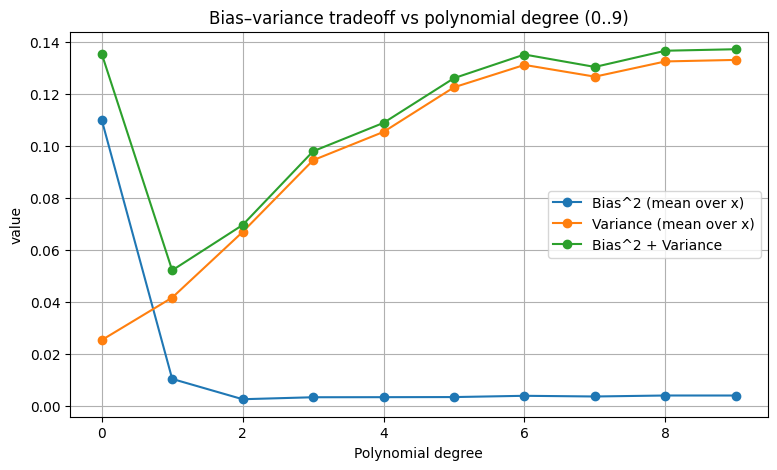

In [13]:
from tqdm import tqdm

results_0_9 = []
for d in tqdm(range(0, 10)):
    lr = 0.2 if d <= 3 else 0.1 if d <= 6 else 0.05
    epochs = 5000 if d <= 3 else 8000
    res = bias_variance_for_degree(datasets, x_grid, degree=d, lr=lr, epochs=epochs, batch_size=len(x_grid))
    results_0_9.append(res)

degrees_0_9 = np.array([r["degree"] for r in results_0_9])
bias2_0_9 = np.array([r["bias2_mean"] for r in results_0_9])
var_0_9 = np.array([r["var_mean"] for r in results_0_9])
total_0_9 = bias2_0_9 + var_0_9

plt.figure()
plt.plot(degrees_0_9, bias2_0_9, marker="o", label="Bias^2 (mean over x)")
plt.plot(degrees_0_9, var_0_9, marker="o", label="Variance (mean over x)")
plt.plot(degrees_0_9, total_0_9, marker="o", label="Bias^2 + Variance")
plt.title("Bias–variance tradeoff vs polynomial degree (0..9)")
plt.xlabel("Polynomial degree")
plt.ylabel("value")
plt.legend()
plt.show()


## 12) Push to degree 100 and look for double descent

We sweep degrees up to 100. High-degree polynomials can be tricky; we already stabilized features,
and we use a conservative learning-rate/epochs schedule.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [34:41<00:00, 20.61s/it]


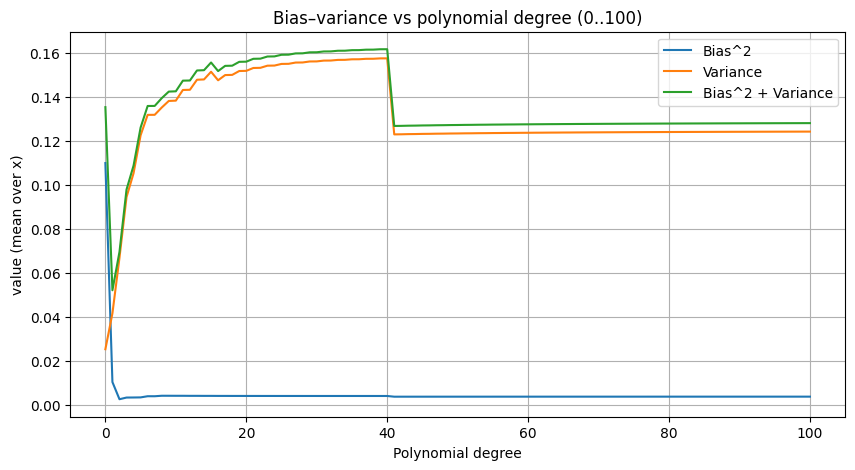

(11, 10)

In [16]:
from tqdm import tqdm

def sweep_degrees(datasets, x_grid, degrees):
    out = []
    try:
        for d in tqdm(degrees):
            if d <= 5:
                lr, epochs = 0.2, 6000
            elif d <= 15:
                lr, epochs = 0.1, 9000
            elif d <= 40:
                lr, epochs = 0.05, 14000
            else:
                lr, epochs = 0.001, 22000

            res = bias_variance_for_degree(datasets, x_grid, degree=int(d), lr=lr, epochs=epochs, batch_size=len(x_grid))
            out.append(res)
    except KeyboardInterrupt:
        pass
    return out

degrees_0_100 = list(range(0, 101))
results_0_100 = sweep_degrees(datasets, x_grid, degrees_0_100)

deg = np.array([r["degree"] for r in results_0_100])
bias2 = np.array([r["bias2_mean"] for r in results_0_100])
varr = np.array([r["var_mean"] for r in results_0_100])
total = bias2 + varr

plt.figure(figsize=(10, 5))
plt.plot(deg, bias2, label="Bias^2")
plt.plot(deg, varr, label="Variance")
plt.plot(deg, total, label="Bias^2 + Variance")
plt.title("Bias–variance vs polynomial degree (0..100)")
plt.xlabel("Polynomial degree")
plt.ylabel("value (mean over x)")
plt.legend()
plt.show()

n_points = len(x_grid)
interp_degree = n_points - 1
n_points, interp_degree


## 13) Theory: the bias–variance decomposition

Consider:
$$ y = f(x) + \epsilon, \quad \mathbb{E}[\epsilon]=0, \ \mathrm{Var}(\epsilon)=\sigma^2. $$

A learning algorithm trained on a dataset $\mathcal{D}$ produces a predictor $\hat f_{\mathcal{D}}(x)$.
For fixed input $x$, define:

- Mean predictor over datasets:
  $$ \bar f(x) = \mathbb{E}_{\mathcal{D}}[\hat f_{\mathcal{D}}(x)]. $$

- Bias (signed):
  $$ \mathrm{Bias}(x) = \bar f(x) - f(x). $$

- Variance:
  $$ \mathrm{Var}(x) = \mathbb{E}_{\mathcal{D}}\big[(\hat f_{\mathcal{D}}(x) - \bar f(x))^2\big]. $$

Then:
$$ \mathbb{E}_{\mathcal{D},\epsilon}\big[(y - \hat f_{\mathcal{D}}(x))^2\big]
= \underbrace{\sigma^2}_{\text{noise}} + \underbrace{\mathrm{Bias}(x)^2}_{\text{bias}^2} + \underbrace{\mathrm{Var}(x)}_{\text{variance}}. $$

In this notebook we estimate bias^2 and variance empirically by:
- sampling many datasets $\mathcal{D}_1,\dots,\mathcal{D}_D$
- training one model per dataset using SGD
- evaluating predictions on the same x-grid
- computing empirical means/variances across datasets,
then averaging across x-grid values to get one scalar per polynomial degree.


# 14) Intuitive explanation of double descent

For high degree polynomials, a small variation of one of its coefficients may lead to a big change in the value of `y`. This will then scatter the stochastic gradient descent towards a region of the landscape with flatter surfaces. Thus, double descent is basically equivalent to adding a ridge regularization term. The possible landscape is artificially depicted here below.

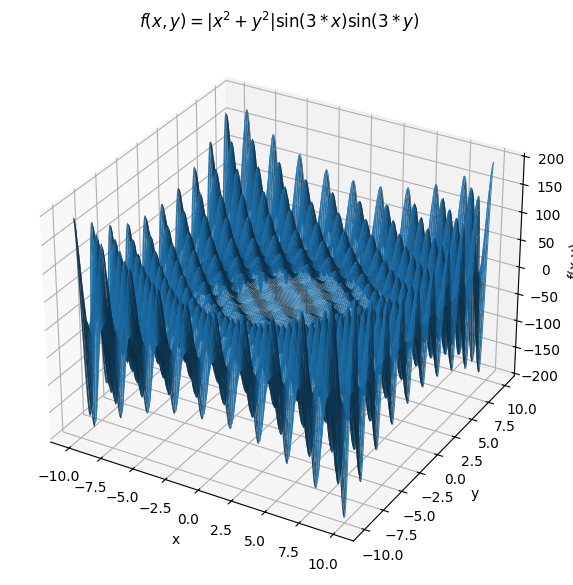

In [15]:
# 3D surface plot: sqrt(x^2 + y^2) * sin(x) * sin(y)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)

# Grid
x = np.linspace(-10, 10, 300)
y = np.linspace(-10, 10, 300)
X, Y = np.meshgrid(x, y)

# Function
Z = np.abs(X**2 + Y**2) * np.sin(3*X) * np.sin(3*Y)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    X, Y, Z,
    rstride=2,
    cstride=2,
    linewidth=0,
    antialiased=True,
    alpha=0.9
)

ax.set_title(r"$f(x,y)=|x^2+y^2|\sin(3*x)\sin(3*y)$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")

plt.show()
